#### Part 28: Advanced Rolling Operations and GroupBy Basics

In this notebook, we'll explore:
- Advanced rolling window operations with custom functions
- Using Numba for performance optimization
- Weighted rolling windows
- Introduction to GroupBy operations

##### Setup
First, let's import the necessary libraries:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set the plotting style
plt.style.use('ggplot')

# Make plots appear in the notebook
%matplotlib inline

##### 1. Rolling Apply with Custom Functions

The `apply()` function allows you to perform generic rolling computations with custom functions. Let's create a sample time series first:

In [3]:
# Create a Series for rolling window examples
s = pd.Series(np.random.randn(1000), index=pd.date_range('1/1/2000', periods=1000))
s = s.cumsum()
s.head()

2000-01-01   -0.150257
2000-01-02    1.255397
2000-01-03    1.182216
2000-01-04    2.235667
2000-01-05    1.212131
Freq: D, dtype: float64

Now, let's define a custom function to compute the mean absolute deviation on a rolling basis:

In [4]:
def mad(x):
    return np.fabs(x - x.mean()).mean()

<Axes: title={'center': 'Rolling Mean Absolute Deviation'}>

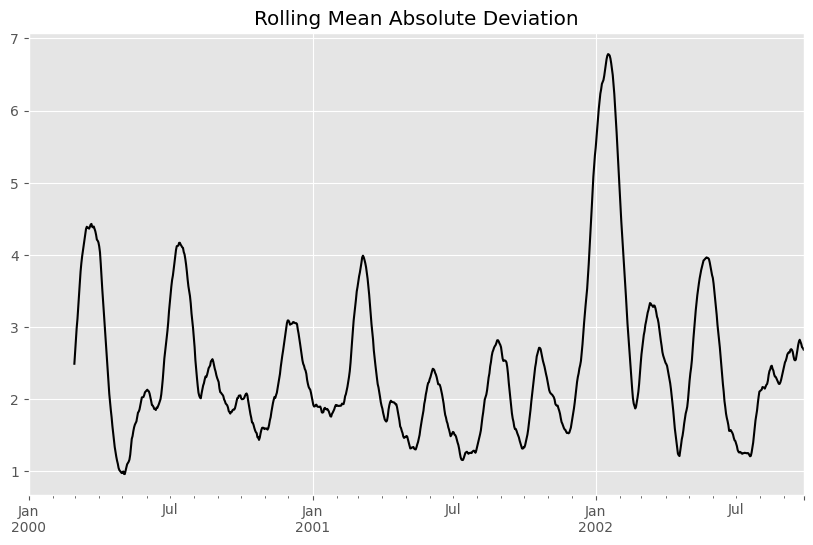

In [5]:
# Apply the custom function to a rolling window
s.rolling(window=60).apply(mad, raw=True).plot(style='k', figsize=(10, 6), 
                                             title='Rolling Mean Absolute Deviation')

##### 2. Using Numba for Performance Optimization

Pandas' `apply()` function can leverage Numba for performance optimization. Numba is a JIT (Just-In-Time) compiler that can significantly speed up Python functions, especially for numerical computations.

To use Numba, you need to specify `engine='numba'` and set `raw=True`. Let's see an example:

In [6]:
# Create a large Series for performance comparison
data = pd.Series(range(1_000_000))
roll = data.rolling(10)

In [7]:
# Define a simple function for rolling apply
def f(x):
    return np.sum(x) + 5

In [8]:
!which pip

/Users/neo/Downloads/Personal/Projects/pandas-tutorial/venv/bin/pip


In [9]:
!pip install numba


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [10]:
%timeit -r 1 -n 1 roll.apply(f, engine='numba', raw=True)

2.47 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [11]:
# Compare performance: Numba vs Cython
# Note: First run with Numba will be slower due to compilation overhead
%timeit -r 1 -n 1 roll.apply(f, engine='cython', raw=True)

1.27 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [12]:
# Use cython or python engine instead
%timeit -r 1 -n 1 roll.apply(f, raw=True)  # Uses default 'python' engine

1.36 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [13]:
# Second run with Numba will be faster as the function is cached
%timeit roll.apply(f, engine='numba', raw=True)

1.22 s ± 41.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
# Compare with Cython engine
%timeit roll.apply(f, engine='cython', raw=True)

1.23 s ± 34.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


##### 3. Weighted Rolling Windows

You can create weighted rolling windows by passing the `win_type` parameter to the `rolling()` method. The weights used in the window are specified by the `win_type` keyword.

Let's create a small Series to demonstrate this:

In [15]:
# Create a small Series for weighted rolling window examples
ser = pd.Series(np.random.randn(10), 
               index=pd.date_range('1/1/2000', periods=10))
ser

2000-01-01    0.093993
2000-01-02   -1.266038
2000-01-03   -1.231913
2000-01-04   -0.785310
2000-01-05   -0.323006
2000-01-06   -1.848506
2000-01-07   -0.574825
2000-01-08   -0.536886
2000-01-09   -0.996810
2000-01-10    0.620452
Freq: D, dtype: float64

In [17]:
# Apply a triangular window
ser.rolling(window=5, win_type='triang').mean()

2000-01-01         NaN
2000-01-02         NaN
2000-01-03         NaN
2000-01-04         NaN
2000-01-05   -0.891939
2000-01-06   -0.953368
2000-01-07   -0.893710
2000-01-08   -0.962597
2000-01-09   -0.868342
2000-01-10   -0.664665
Freq: D, dtype: float64

Let's compare different window types visually:

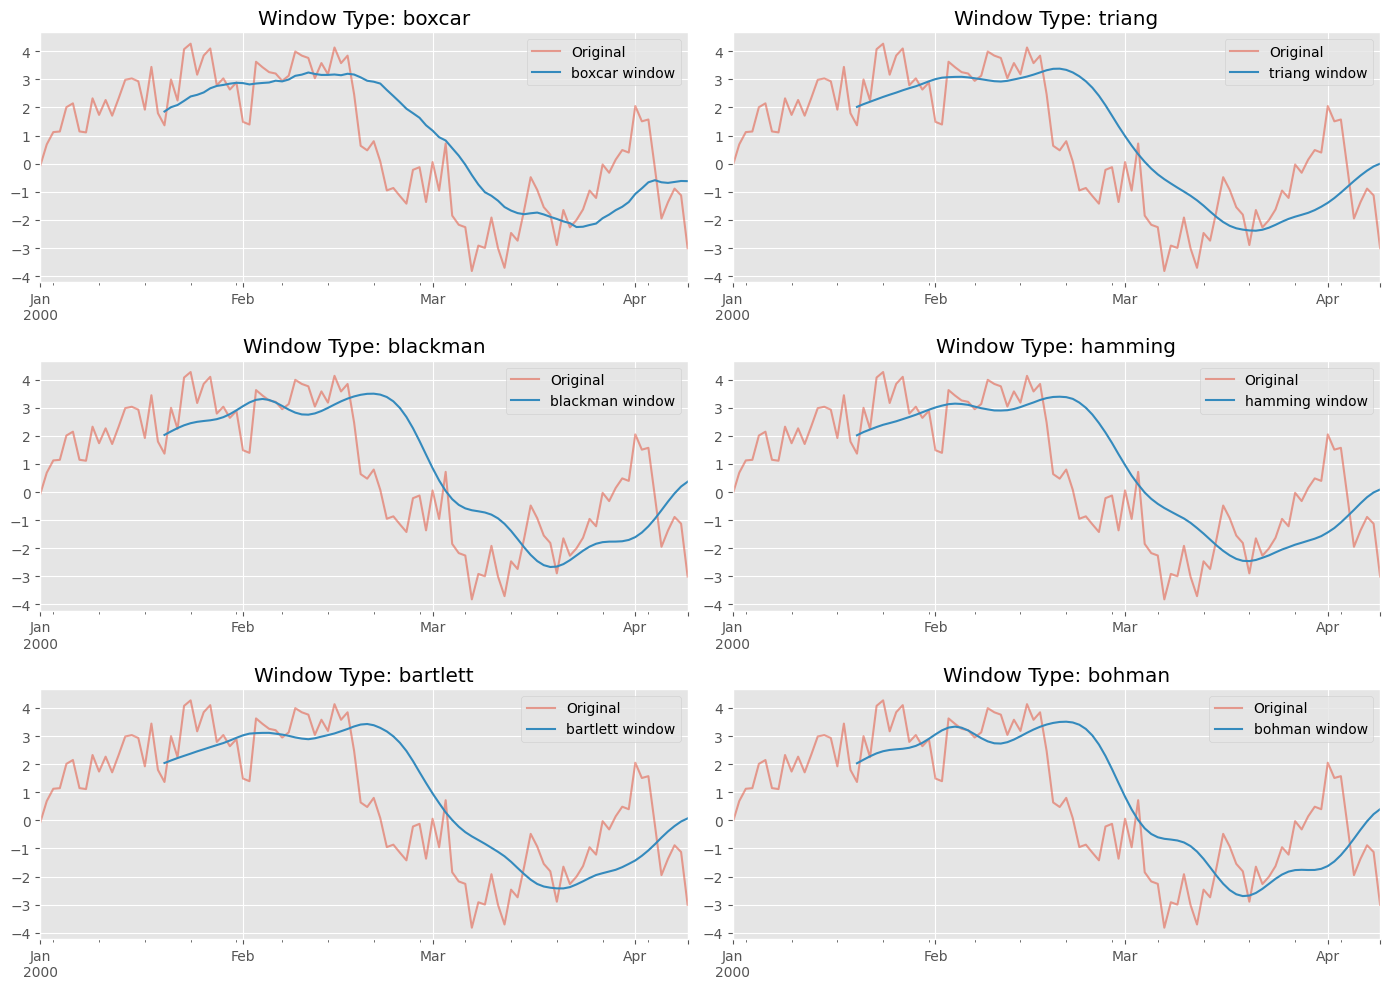

In [18]:
# Create a larger Series for visualization
larger_ser = pd.Series(np.random.randn(100).cumsum(), 
                      index=pd.date_range('1/1/2000', periods=100))

# Create a figure with multiple window types
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
window_types = ['boxcar', 'triang', 'blackman', 'hamming', 'bartlett', 'bohman']

# Plot original data on all subplots
for i, ax in enumerate(axes.flatten()):
    larger_ser.plot(ax=ax, alpha=0.5, label='Original', legend=True)
    if i < len(window_types):
        # Apply the window type
        win_type = window_types[i]
        larger_ser.rolling(window=20, win_type=win_type).mean().plot(
            ax=ax, label=f'{win_type} window', legend=True)
        ax.set_title(f'Window Type: {win_type}')

plt.tight_layout()

##### 4. Introduction to GroupBy Operations

GroupBy operations allow you to split your data into groups, apply a function to each group independently, and then combine the results. This is often referred to as the "split-apply-combine" pattern.

Let's start with a simple example:

In [19]:
# Create a simple Series with repeating indices
s = pd.Series([1, 2, 3, 10, 20, 30], index=[1, 2, 3, 1, 2, 3])
s

1     1
2     2
3     3
1    10
2    20
3    30
dtype: int64

In [20]:
# Group by index
grouped = s.groupby(level=0)
grouped

In [21]:
# Get the first value in each group
grouped.first()

1    1
2    2
3    3
dtype: int64

In [22]:
# Get the last value in each group
grouped.last()

1    10
2    20
3    30
dtype: int64

In [23]:
# Sum the values in each group
grouped.sum()

1    11
2    22
3    33
dtype: int64

### 4.1 GroupBy Sorting

By default, the group keys are sorted during the groupby operation. You can pass `sort=False` for potential speedups:

In [24]:
# Create a DataFrame for groupby examples
df2 = pd.DataFrame({'X': ['B', 'B', 'A', 'A'], 'Y': [1, 2, 3, 4]})
df2

,X,Y
0,B,1
1,B,2
2,A,3
3,A,4


In [25]:
# Default sorting (alphabetical)
df2.groupby(['X']).sum()

,Y
X,
A,7
B,3


In [26]:
# No sorting (order of appearance)
df2.groupby(['X'], sort=False).sum()

,Y
X,
B,3
A,7


GroupBy will preserve the order in which observations are sorted within each group:

In [27]:
# Create another DataFrame for groupby examples
df3 = pd.DataFrame({'X': ['A', 'B', 'A', 'B'], 'Y': [1, 4, 3, 2]})
df3

,X,Y
0,A,1
1,B,4
2,A,3
3,B,2


In [28]:
# Get group 'A' - order is preserved
df3.groupby(['X']).get_group('A')

/var/folders/7y/fzwln1_93mn3js3wyk61_6xm0000gn/T/ipykernel_76009/2557640751.py:2: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df3.groupby(['X']).get_group('A')


,X,Y
0,A,1
2,A,3


In [29]:
# Get group 'B' - order is preserved
df3.groupby(['X']).get_group('B')

/var/folders/7y/fzwln1_93mn3js3wyk61_6xm0000gn/T/ipykernel_76009/1882881691.py:2: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df3.groupby(['X']).get_group('B')


,X,Y
1,B,4
3,B,2


### 4.2 GroupBy Object Attributes

The `groups` attribute is a dict whose keys are the computed unique groups and corresponding values being the axis labels belonging to each group.

In [30]:
# Create a DataFrame for more complex groupby examples
df = pd.DataFrame({'A': ['foo', 'bar', 'foo', 'bar', 'foo', 'bar', 'foo', 'foo'],
                  'B': ['one', 'one', 'two', 'three', 'two', 'two', 'one', 'three'],
                  'C': np.random.randn(8),
                  'D': np.random.randn(8)})
df

,A,B,C,D
0,foo,one,0.561973,0.387371
1,bar,one,-1.356418,-0.799563
2,foo,two,0.119433,-2.087993
3,bar,three,-0.333610,-1.105017
4,foo,two,-0.575127,1.132730
5,bar,two,-0.127072,-1.602119
6,foo,one,0.921933,-1.004262
7,foo,three,0.255003,1.517210


In [31]:
# Get the groups when grouping by column 'A'
df.groupby('A').groups

{'bar': [1, 3, 5], 'foo': [0, 2, 4, 6, 7]}

In [32]:
# Define a function to identify vowels and consonants
def get_letter_type(letter):
    if letter in 'aeiou':
        return 'vowel'
    else:
        return 'consonant'

In [33]:
# Group by a function along axis=1 (columns)
df.groupby(get_letter_type, axis=1).groups

/var/folders/7y/fzwln1_93mn3js3wyk61_6xm0000gn/T/ipykernel_76009/1748327595.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df.groupby(get_letter_type, axis=1).groups


{'consonant': ['A', 'B', 'C', 'D']}

In [34]:
# Group by multiple columns
grouped = df.groupby(['A', 'B'])
grouped.groups

{('bar', 'one'): [1], ('bar', 'three'): [3], ('bar', 'two'): [5], ('foo', 'one'): [0, 6], ('foo', 'three'): [7], ('foo', 'two'): [2, 4]}

In [35]:
# Get the number of groups
len(grouped)

6

Let's create a different DataFrame with a DatetimeIndex to demonstrate more GroupBy functionality:

In [36]:
# Create a DataFrame with a DatetimeIndex
df = pd.DataFrame({
    'height': np.random.normal(loc=60, scale=10, size=8),
    'weight': np.random.normal(loc=160, scale=15, size=8),
    'gender': np.random.choice(['male', 'female'], size=8)
}, index=pd.date_range('1/1/2000', periods=8))
df

,height,weight,gender
2000-01-01,76.769640,147.039514,male
2000-01-02,55.993471,158.372644,female
2000-01-03,48.200653,157.940421,male
2000-01-04,67.279654,162.666886,male
2000-01-05,63.583662,144.622017,male
2000-01-06,65.233189,166.797508,male
2000-01-07,73.494283,177.620158,female
2000-01-08,64.797383,159.726791,male


##### Summary

In this notebook, we've explored:

1. Advanced rolling operations with custom functions using `apply()`
2. Performance optimization with Numba for rolling operations
3. Weighted rolling windows with various window types
4. Introduction to GroupBy operations, including:
   - Basic groupby functionality
   - GroupBy sorting options
   - GroupBy object attributes

These techniques provide powerful tools for time series analysis and data aggregation in pandas.